In [1]:
import numpy as np
from scipy.signal import lfilter, lfilter_zi, freqz, iirfilter

%matplotlib inline
import matplotlib.pyplot as plt

# The IIR Filter

The IIR filter is the most generic linear (time-invariant) filter that is commonly used in digital signal processing. That's a lot of words and they mostly don't matter. In case the details interest you they're below, otherwise skip to the next section.

* [Linear](https://en.wikipedia.org/wiki/Linear_system) the relationship between the input and the output of the system is a [linear map](https://en.wikipedia.org/wiki/Linear_map). The inputs are only modified by the multiplication and addition of scalars, inputs themselves are not multiplied by eachother.
* [Time-invariant](https://en.wikipedia.org/wiki/Time-invariant_system) essentially means that the process that is applied to a set of inputs is the same in the past, present, and future.

Linear time-invariant ([LTI](https://en.wikipedia.org/wiki/Linear_time-invariant_system)) systems can be analized in both continous and discrete time domains. Since we are mostly interested in practical implementations of these filters on computers we will discuss the [discrete-time](https://en.wikipedia.org/wiki/Linear_time-invariant_system) version of the filter. All this means is that we sample the signal at some frequency.

## The equations

There are a couple different ways to write the IIR filter equations, namely [Direct Form 1](https://ccrma.stanford.edu/~jos/filters/Direct_Form_I.html) and [Direct Form 2](https://ccrma.stanford.edu/~jos/filters/Direct_Form_II.html). They both do the same thing in slightly different wasy, in practial implementations (i.e. on a computer) each one has its own benefits. We won't bother with this for now so let's consider the Direct-Form I implementation as it's slightly easier to understand. The signal flow diagram is

![Direct Form I](./figures/iir_direct_form_1.png)

and the corresponding difference euqations can be written as

$$y_n=\sum_{b_i=0}^{M}b_i\;x_{n-i}-\sum_{j=1}^{N} a_j\;y_{n-j}$$

where

* $x_n$ is the input signal
* $y_n$ is the output signal
* $M$ is the feed-back filter order
* $N$ is the feed-forward filter order
* $a_j$ is the $j$-th feed-back filter coefficient. Note that by definition $a_0 = 1$
* $b_i$ is the $i$-th feed-forward filter coefficient

Observing the signal flow diagram above we can see that this is essentially two cascaded filters. 

The first is a feed-forward filter. In this section the singal $x_n$ arrives one sample at a time and the last $M$ are kept in what is known as the 'delay line', including the current sample $x_0$. For example, if we have a third order filter ($M=3$) we have three feed-forward coefficients. When the next sample of our input signal arrives, we place it into the delay line and discard the oldest value such that there are three samples in the delay line. These are then multiplied by their corresponding feed-forward coefficients $b_n$, then their sum propagates to the next section of the filter. Note that if we consider just this part of the filter what we have is an FIR filter, in which case $a_0 = 1$ and all other feed-back coefficients are defined to be zero.

The next part of the IIR filter is the feed-back section. Similar to the feed-forward section of the filter this has it's own delay line, the main difference is that this delay line keeps track of the last $N$ output values $y_n$. As a new output is calculated it is placed into the beginning of the delay line and the oldest value is discarded. These values are then multiplied by the corresponding feed-back coefficients and their summation proceeds to the output of the filter as the value $y_n$.

An interesting but unimportant note is that each of these sections of the IIR filter essentially performs a [discrete convolution](https://en.wikipedia.org/wiki/Convolution) operation. 

## Filter Design Example Using Python

For now we won't bother with how to calculate or analysie the coefficients of an IIR filter. Instead we'll rely on the SciPy library in Python to do that for us.

First, let's create a signal we'd like to filter.

In [2]:
Fs = 100  # sampling frequency [Hz]
T = 1 / Fs  # sampling interval [seconds]
sample_len_s = 2  # signal length [seconds]

tt = np.arange(sample_len_s * Fs) * T
yy = np.sin(2 * np.pi * 2 * tt) + np.sin(2 * np.pi * 10 * tt) + 1

In the code above we create time samples 'tt' for $2$ seconds at a sampling frequency of $100Hz$. We then create a signal that is the sum of two sine waves, one at $2Hz$ and one at $10Hz$, with a DC offset of $1$. The resulting signal can be seen in the figure below.

Text(0.5, 0, 'Time [s]')

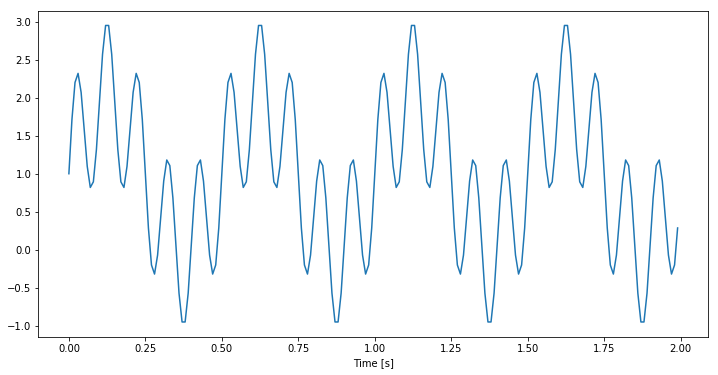

In [3]:
f = plt.figure(figsize=(12, 6))
ax = f.add_subplot(111)
ax.plot(tt, yy)
ax.set_xlabel('Time [s]')

Now that we have a signal we'd like to filter, let's use Python to calculate the filter coefficients

In [4]:
nyq_rate = Fs / 2  # filter nyquist rate, the filter properties are normalized to this value
cutoff_hz = 4  # our desired cutoffer frequency for the filter [Hz]
N_ord = 4  # our desired filter order, we will have N+1 coefficients

b, a = iirfilter(N_ord, cutoff_hz/nyq_rate, rp=1, rs=40, btype='lowpass', analog=False, ftype='butter')

The above code calculates the coefficients for our IIR filter using the [iirfilter](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.iirfilter.html) function from SciPy. 

The filer response type is specified with the argument **btype**

* Band-pass : ‘bandpass’
* Low-pass : ‘lowpass’
* High-pass : ‘highpass’
* Band-stop : ‘bandstop’

The filter type is specified with the argument **ftype**

* Butterworth : ‘butter’
* Chebyshev I : ‘cheby1’
* Chebyshev II : ‘cheby2’
* Cauer/elliptic: ‘ellip’
* Bessel/Thomson: ‘bessel’



Digital filters have no notion of sampling and cutoff frequencies, these properties are implicitly captured by the filter coefficients and depend on the rate at which the filter is fed with samples (e.g. $1000Hz$, in our example). To capture this relationship the *iirfilter* function requires the ratio of the cutoff frequency to the sampling frequency, in our case

$$\frac{\text{cutoff_hz}}{\text{nyq_rate}}=\frac{4\text{Hz}}{100\text{Hz}/2}=0.08$$

which results in the following fitler coefficients. Note that $a_0 = 1$, as mentioned above.

In [5]:
print('b: {}'.format(b))
print('a: {}'.format(a))

b: [0.00018322 0.00073286 0.0010993  0.00073286 0.00018322]
a: [ 1.         -3.34406784  4.23886395 -2.40934286  0.5174782 ]


In python we can apply the fitler to arbitrary data using the [lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html) function, as shown below

In [6]:
# If the filter does not need to be initialized with any particular value it will start from 0
# in that case 'lfilter' is used as below
yy_filtered = lfilter(b, a, yy)

# To start the filter from some (non-zero) initial condition, we must first find the
# steady-state (step) response of the filter delay-line, we can then multiply this by any value
zi = lfilter_zi(b, a)  # compute initial (delay-line) state (steady state of step response)
yy_filtered_ic, _ = lfilter(b, a, yy, zi=zi*yy[0])  # multiply the steady state by the value of our data

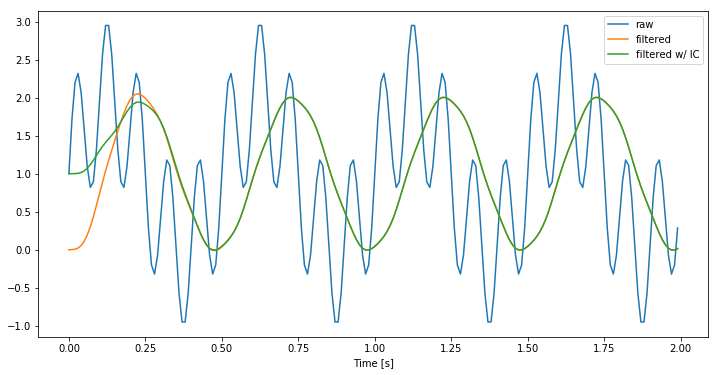

In [7]:
f = plt.figure(figsize=(12, 6))
ax = f.add_subplot(111)
ax.plot(tt, yy, linestyle='-', label='raw')
ax.plot(tt, yy_filtered, linestyle='-', label='filtered')
ax.plot(tt, yy_filtered_ic, linestyle='-', label='filtered w/ IC')
ax.set_xlabel('Time [s]')
ax.legend()

## Initial conditions

Now might be a good time to elaborate on initial conditions. In the graph above we can see that the filter responds differently at the start, depending on wheather or not it was initialized. Technially both were initialized but one was initialized with a delay line that had values all equal to zero.

To initialize the filter at an arbitrary starting value we must first find it's stead-state step-response, that is $x_n = y_n = 1$ as $n\rightarrow \infty$. This calculation depends on the implementation of the filter (e.g. Direct Form I, Direct Form II, etc.). In SciPy the *lfilter* function uses the [Direct Form II](https://ccrma.stanford.edu/~jos/filters/Direct_Form_II.html) implementation, giving the values $zi$ for only one delay line.

There is also a naive (easy) way to do this, simply feed some large numebr of $1$'s into the filter until the output settles (hopefully also to $1$) and store the delay-line values. If the filter does not settle close to $1$ you might be dealing with round-off errors or unstable filter coefficients.

Anyways, we're not actually going to demonstrate how to do this as it's not super useful and depends on the filter implementation.

## Filter Response

The [frequency response](https://en.wikipedia.org/wiki/Frequency_response) of a filter tells us how the filter will react to different input frequencies. More specifically it lets us know how certain frequencies are attenuated or shifted in phase. Using the [*freqz*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html) function from SciPy we can easily view the frequency response of the filter.

In [8]:
# Calculate the frequency response 'h' at the complex frequencies 'w'
# Note that 'w' is returned in the same units as 'Fs'
w, h = freqz(b, a, worN=8192)

w_hz = w * (Fs/(2*np.pi)) # 'convert 'w' from radians to Hz
h_db = 20 * np.log10(np.abs(h)) # convert 'h' from complex magitude to dB
angles = np.unwrap(np.angle(h)) * (180/np.pi)

Text(0, 0.5, 'angle [deg]')

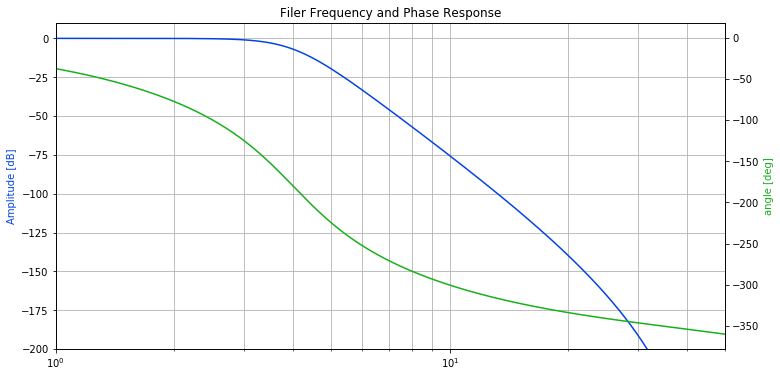

In [9]:
f = plt.figure(figsize=(12, 6))
ax1 = f.add_subplot(111)

ax1.plot(w_hz, 20*np.log(np.abs(h)), color='xkcd:blue')

ax1.set_xscale('log')
ax1.set_xlim([1, Fs/2])
ax1.grid(which='both', axis='both')
ax1.set_ylabel('Amplitude [dB]', color='xkcd:blue')
ax1.set_title('Filer Frequency and Phase Response')
ax1.set_ylim([-200, 10])

ax2 = ax1.twinx()
ax2.plot(w_hz, angles, color='xkcd:green')
ax2.set_ylabel('angle [deg]', color='xkcd:green')